In [1]:
import numpy as np
import qubogen
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from pulser.devices import DigitalAnalogDevice
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator

# Fonctions

In [2]:
def qubo(size):
    s = np.random.randint(size)
    Q = qubogen.qubo_number_partition(s)
    return Q

def soluce(Q):
    bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
    costs = []
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q @ z
        costs.append(cost)
    zipped = zip(bitstrings, costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])
    print(sort_zipped[:l])
    indexes = sort_zipped[:l]
    indexes = [item[0] for item in indexes if '0' in item[0] and '1' in item[0]]
    return indexes

def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(24, 12))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

# Running

In [3]:
size = 4

In [4]:
s = np.random.randint(1,19,size)

In [5]:
Q = np.array([[-272,   24,   88,   72,   16,   72],
 [  24, -117,   33,   27,    6,   27],
 [  88,   33, -341,   99,   22,   99],
 [  72,   27,   99, -297,   18 ,  81],
 [  16 ,   6 ,  22,  18,  -80  , 18],
 [  72 ,  27 ,  99 ,  81,   18, -297]])

In [6]:
match len(s):
    case 2:
        l = 2
    case 3:
        l = 4
    case 4:
        l = 6
    case 5:
        l = 10
    case 6:
        l = 20
    case 7:
        l = 50
    case 8:
        l = 220     

In [7]:
Q = qubogen.qubo_number_partition(s)

In [8]:
Q

array([[-598,  130,  234,  234],
       [ 130, -490,  180,  180],
       [ 234,  180, -738,  324],
       [ 234,  180,  324, -738]])

In [9]:
l = 20

In [10]:
indexes = soluce(Q)

[('0101', -868), ('0110', -868), ('1001', -868), ('1010', -868), ('0011', -828), ('1100', -828), ('0001', -738), ('0010', -738), ('1101', -738), ('1110', -738), ('0111', -598), ('1000', -598), ('0100', -490), ('1011', -490), ('0000', 0), ('1111', 0)]


In [11]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)

#
coords = np.reshape(res.x, (len(Q), 2))

In [12]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
# reg.draw(
#     blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
#     draw_graph=False,
#     draw_half_radius=True,
# )

In [13]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [14]:
np.random.seed()  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [15]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

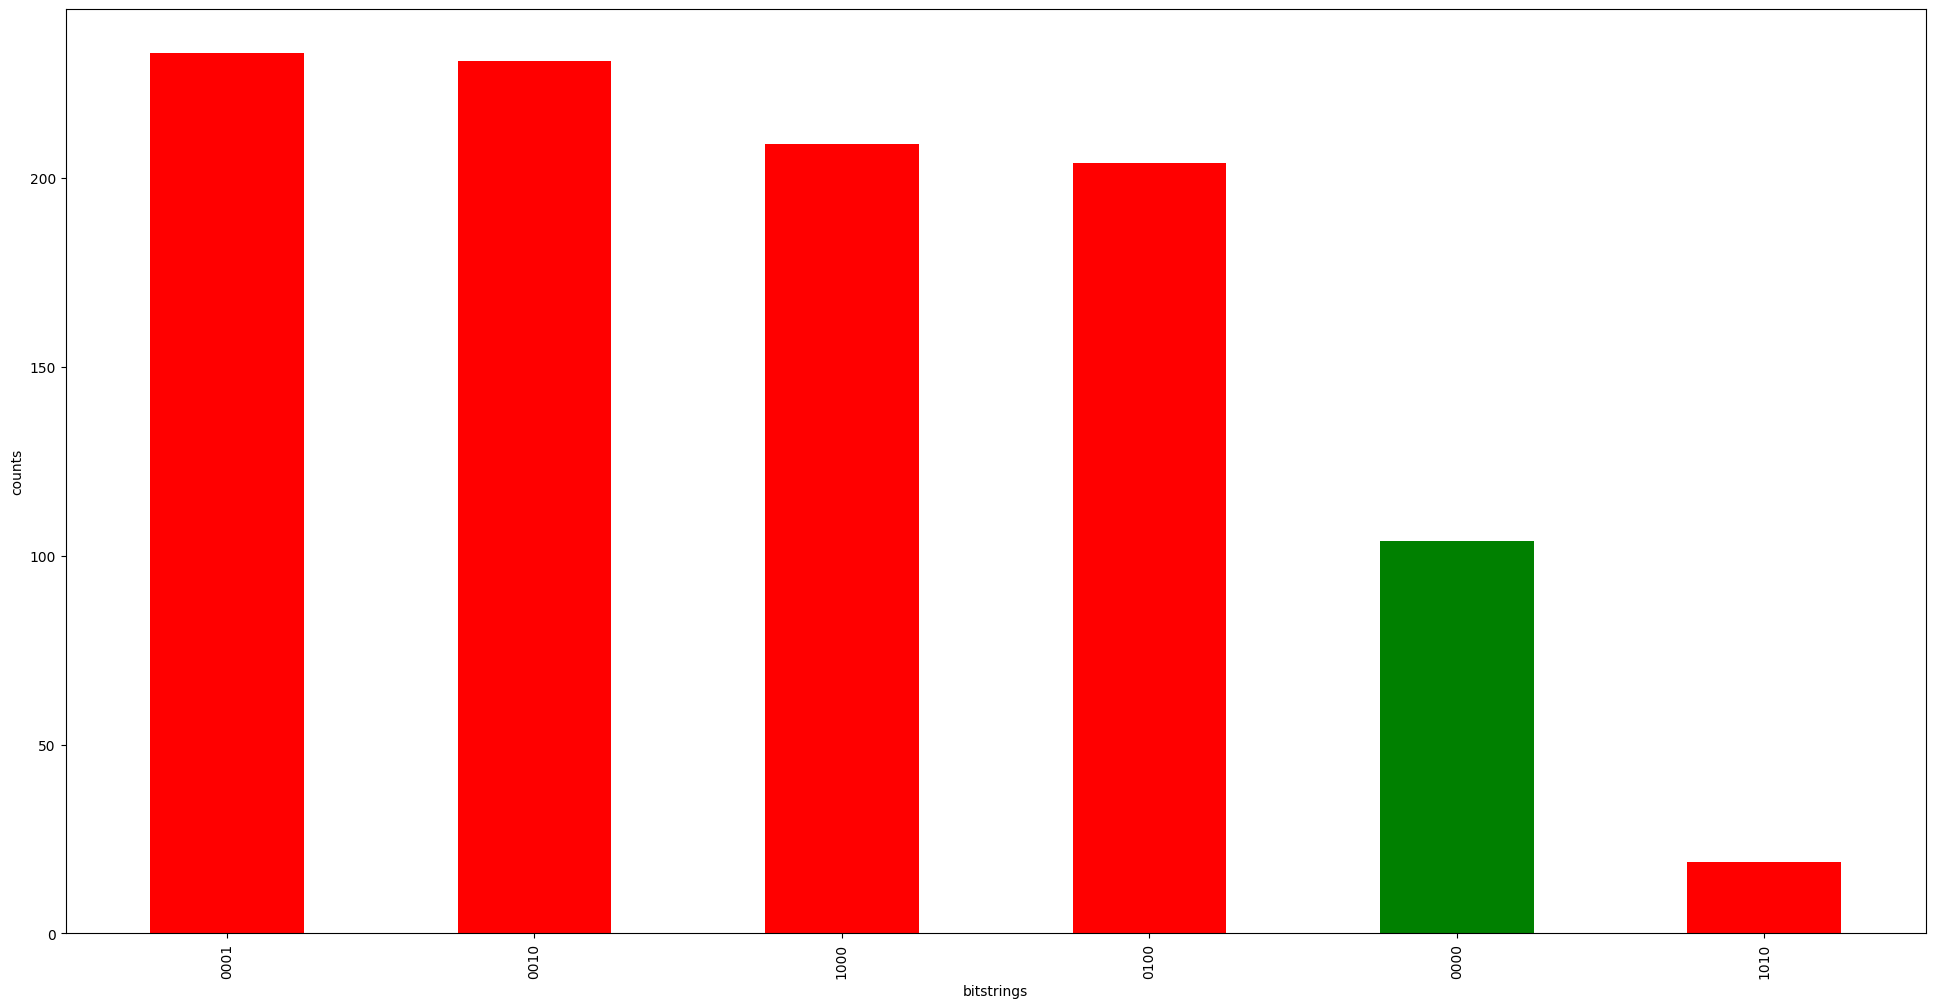

In [16]:
plot_distribution(example_dict)

See how you can modify the parameters to influence time resolution and results

In [18]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 20},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

In [19]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
#plot_distribution(optimal_count_dict)

In [20]:
yes_match = {}
no_match = {}

for key in optimal_count_dict.keys():
    if key in indexes:
        yes_match[key] = optimal_count_dict[key]
    else:
        no_match[key] = optimal_count_dict[key]

sorted_match = dict(sorted(yes_match.items(), key=lambda item: item[1], reverse=True))
print("Matching keys:count", sorted_match)
print("Non-matching keys:count", no_match)

Matching keys:count {'0010': 258, '1000': 255, '0001': 242, '0100': 241, '1010': 3}
Non-matching keys:count {'0000': 1}
